# Review RPG Game Demo ML

This notebook uses the SAS ESPPY project to connect to an pull stream information from a SAS ESP Server.

Let's do some standard imports, as well as connect to the ESP server:
    `conn = esppy.ESP(<server_addr>, <http_port>)`
    
Verify the connection by pulling up some information on the server:
    `conn.server_info`

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import esppy
conn = esppy.ESP('10.104.90.199', '5997')

# show the server info (verifies we're connected)
conn.server_info

{'version': '5.2',
 'engine': 'esp',
 'analytics-license': True,
 'pubsub': 5994,
 'http': 5997}

Note the results of the `conn.server_info`, it's telling us we're connected to a SAS ESP 5.2 server, which is licensed for running analytics.

From here we'll want to get our project using the `conn.get_project(<project_name>)` function, note that this expects the project is already deployed and running on the connected server.

In [2]:
# Get the project
project = conn.get_project('rpggame_demo_ml')

With the project we can take a look at the structure of the project including the window schema showing the output schema using the `<project_var>.to_graph(schema=True)` function:

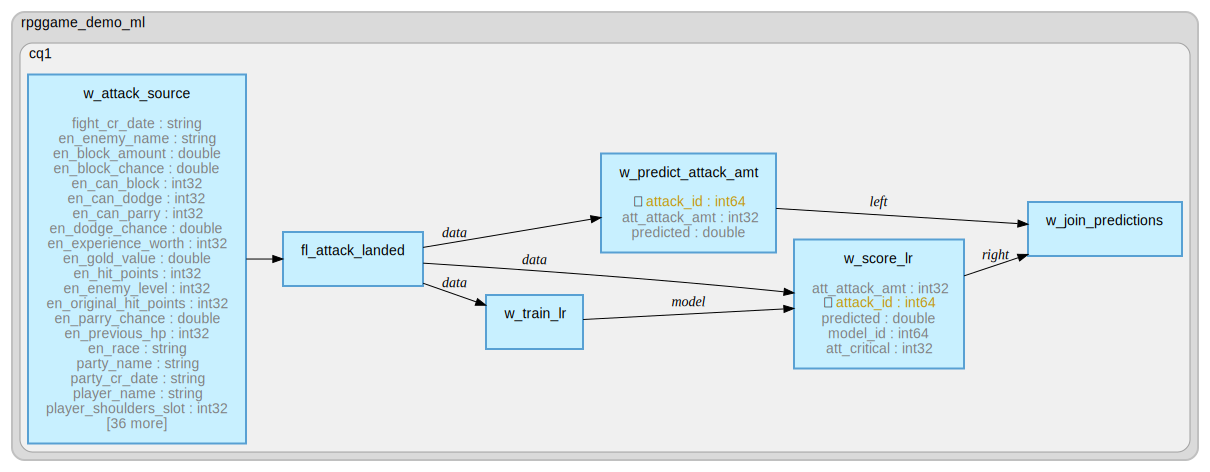

In [11]:
# show the project schema
project.to_graph(schema=True)

In [3]:
# get the w_join_predictions window
attack_w = project['cq1']['w_join_predictions']

### Subscribe to the window

Note `window.subscribe()` will keep an active open connection to the window and will load new events as they occur.

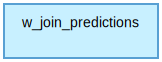

In [8]:
# subscribe
attack_w.subscribe()
attack_w

In [12]:
# take a look at what the window looks like
attack_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7029 entries, 1462734371625905685 to 2268800676468567125
Data columns (total 4 columns):
att_attack_amt    7029 non-null int32
py_predicted      7029 non-null float64
esp_predicted     7029 non-null float64
att_critical      7029 non-null int32
dtypes: float64(2), int32(2)
memory usage: 219.7 KB


### Visualize the predictions

Create plots which depict the predictions against the `att_attack_amt`, show the `py_predicted` which was done by the *MAS Python Module* (offline), and the `esp_predicted` value which was done using online scoring with ESP transformations.

Use the `points` variable to determine how many predictions to plot in each graph.


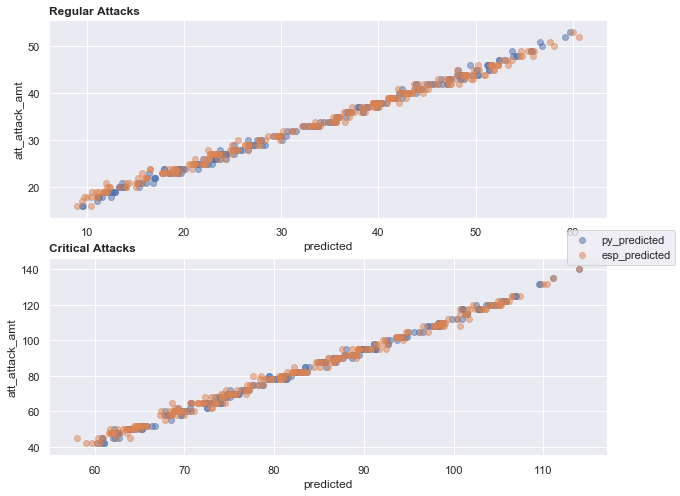

In [10]:
points = 250 # configurable value to change how many points appear

# filters for df
not_crit = attack_w['att_critical'] == 0
crit = attack_w['att_critical'] == 1

# get the non critical attacks, grab the last n points 
y_1 = attack_w.loc[not_crit, 'att_attack_amt'].tail(points).values.reshape(-1, 1)
x_1 = attack_w.loc[not_crit, 'py_predicted'].tail(points).values.reshape(-1, 1)
x_2 = attack_w.loc[not_crit, 'esp_predicted' ].tail(points).values.reshape(-1, 1)

# get the critical attacks, grab the last n points
y2_1 = attack_w.loc[crit, 'att_attack_amt'].tail(points).values.reshape(-1, 1)
x2_1 = attack_w.loc[crit, 'py_predicted'].tail(points).values.reshape(-1, 1)
x2_2 = attack_w.loc[crit, 'esp_predicted' ].tail(points).values.reshape(-1, 1)

# set up the plot
fig, ax = plt.subplots(2, sharey=False, sharex=False)
fig.set_size_inches((10, 8))

# plot the points
l1 = ax[0].scatter(x_1, y_1, alpha=.5)
l2 = ax[0].scatter(x_2, y_1, alpha=.5)
l2_1 = ax[1].scatter(x2_1, y2_1, alpha=.5)
l2_2 = ax[1].scatter(x2_2, y2_1, alpha=.5)

# do some formatting for titles and labels
ax[0].set_title('Regular Attacks', loc='left', fontdict=dict(fontweight='bold'))
ax[0].set(xlabel='predicted', ylabel='att_attack_amt')

ax[1].set_title('Critical Attacks', loc='left', fontdict=dict(fontweight='bold'))
ax[1].set(xlabel='predicted', ylabel='att_attack_amt')

# configure the legend
line_labels = ['py_predicted', 'esp_predicted']
fig.legend([l1, l2], line_labels, 'center right');


So I split the two regression plots above into a calculation of which attacks were critical strikes which are not as this causes two different slopes when plotted together.

The LinearRegression model used to perform the prediction takes a parameter of *att_critical*, this parameter is not reflected directly above; however, since it is used to calculate the actual *att_attack_amt* value and the predicted amount it shows up in the plot above.